In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [1]:
import pandas as pd
import numpy as np
import os
from os.path import join, isdir, dirname, basename, exists
from os import mkdir

import nibabel as nib

from scipy.stats import t as tdist
import glob as glob
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context="paper",style="white",font_scale=1.5)
from glob import glob

from collections import defaultdict, namedtuple


import matplotlib as mpl

In [2]:
eCON= '/data/bswift-1/Pessoa_Lab/eCON'

yoked = pd.read_excel(join(eCON,'onsetdir/CON_yoked_table.xlsx'))
yoked = yoked.query('use == 1').reset_index()

In [3]:
shock_beta_path = eCON+'/dataset/results_ShockUncensored/{subj}/{group}lable/splitted_regs/ROI_analysis/noProx/buttonPress/shock_deconv/{subj}_bucket_REML_clean.1D'
shock_beta_path = eCON+'/dataset/results_ShockUncensored/{subj}/{group}lable/splitted_regs/ROI_final/noProx/buttonPress/shock_deconv/{subj}_bucket_REML_clean.1D'

In [14]:
ROIs = {'old':'rBNST lBNST rdAI rvAI vmPFC PCC1 rPAG lPAG PCC2 ldAI\
                lvAI rPI lPI rCa lCa rPa lPa rVS lVS Amygdala_BLBM_La_L\
                Amygdala_BLBM_La_R Amygdala_CeME_L Amygdala_CeME_R ACC'.split(),
        'new':['L Amygdala (BLBM)',
               'R Amygdala (BLBM)',
               'L Amygdala (CeME)',
               'R Amygdala (CeME)',
               'L aMCC',
               'R aMCC',
               'L Thalamus (emoproxI shock intersection)',
               'R Thalamus (emoproxI shock intersection)',
               'L Anterior dorsal insula',
               'R Anterior dorsal insula',
               'L Mid posterior insula',
               'R Mid posterior insula',
               'L Anterior ventral insula (anterior pole)',
               'R Anterior ventral insula (anterior pole)',
               'vmPFC (new 5mm sphere from Hartley paper)',
               'L BST',
               'L Anterior hippocampus',
               'L PAG',
               'PCC (1)',
               'PCC (2)',
               'R  BST',
               'R Anterior hippocampus',
               'R PAG',
               'vmPFC (from out lab)']
       }

rois = ROIs['new']

print('Total number of ROIs: ',len(rois))

Total number of ROIs:  24


In [15]:
roi_mapper = {'lBNST': 'Left BNST',
        'ldAI':'Left Dorsal Anterior Insual',
        'lPa': 'Left Anterior Putamen',
        'lvAI':'Left Ventral Anterior Insula',
        'rBNST': 'Right BNST',
        'lVS': 'Left Ventral Striatum',
        'rPa': 'Right Anterior Putamen',
        'rCa': 'Right Anterior Caudate',
        'rdAI':'Right Dorsal Anterior Insula',
        'Amygdala_BLBM_La_L': 'Left Amygdala (BLBM+La)',
        'rvAI':'Right Ventral Anterior Insula',
        'Amygdala_CeME_L': 'Left Central Amygdala',
        'Amygdala_BLBM_La_R': 'Right Amygdala (BLBM_La)',
        'rVS': 'Right Ventral Striatum',
        'lCa': 'Left Anterior Caudate',
        'lPAG':'Left PAG',
        'ACC': 'Anterior Cingulate',
        'Amygdala_CeME_R': 'Right Central Amygdala',
        'lPI': 'Left Posterior Insula',
        'rPAG':'Right PAG',
        'vmPFC':'vmPFC',
        'rPI': 'Right Posterior Insula',
        'PCC1':'PCC1',
        'PCC2':'PCC2'}

In [16]:
response = np.loadtxt(shock_beta_path.format(subj='CON001',group='control'))[:,-24:][:,::2]
response.shape[1]

12

In [17]:
if exists('data/EstimatedShockResp_newROIs.txt'):
    df = pd.read_csv('data/EstimatedShockResp_newROIs.txt')
else:
    df = pd.DataFrame()
    for i, row in yoked.iterrows():
        for group in 'control uncontrol'.split():
            response = np.loadtxt(shock_beta_path.format(subj=row[group],group=group))[:,-24:][:,::2]
            tmp_df = pd.DataFrame(response,index=rois).T
            tmp_df['Time'] = np.arange(response.shape[1])*1.25
            tmp_df['SubjID'] = row[group]
            tmp_df['Group'] = group
            tmp_df['Pair'] = 'P{:02d}'.format(i)
            df = pd.concat([df,tmp_df],axis = 0)
    df = df.melt(id_vars=['Pair','Group','SubjID','Time'],var_name='ROI',value_name='Response')
    df.to_csv('data/EstimatedShockResp_newROIs.txt',sep=',',index=False)

In [18]:
df.head()

,Pair,Group,SubjID,Time,ROI,Response
0,P00,control,CON001,0.00,L Amygdala (BLBM),-0.174588
1,P00,control,CON001,1.25,L Amygdala (BLBM),0.097325
2,P00,control,CON001,2.50,L Amygdala (BLBM),-0.185749
3,P00,control,CON001,3.75,L Amygdala (BLBM),-0.147403
4,P00,control,CON001,5.00,L Amygdala (BLBM),-0.079528


In [19]:
df.Time.unique().shape

(12,)

In [20]:
print('Total %d rois' %(len(list(df.ROI.unique()))))
N = len(df['Pair'].unique())
print('Total %d yoke pairs' %(N))

Total 24 rois
Total 61 yoke pairs


In [21]:
cross_subj_mean_df = df.groupby(['Time','ROI','Group'])['Response'].mean().reset_index()

from scipy.stats import sem
cross_subj_se_df = df.groupby(['Time','ROI','Group'])['Response'].agg(sem).reset_index()

In [22]:
from scipy.stats import t as tdist

critT = tdist(df=N-1).ppf(0.975)
t = df.Time.unique()
cmap = plt.get_cmap('Set1')
HRF = np.loadtxt(join(eCON,'scripts/tmp_preproc2/canonical_reps_dur0.9557145s.1D'))

# Visualizing estimated shock responses for both groups

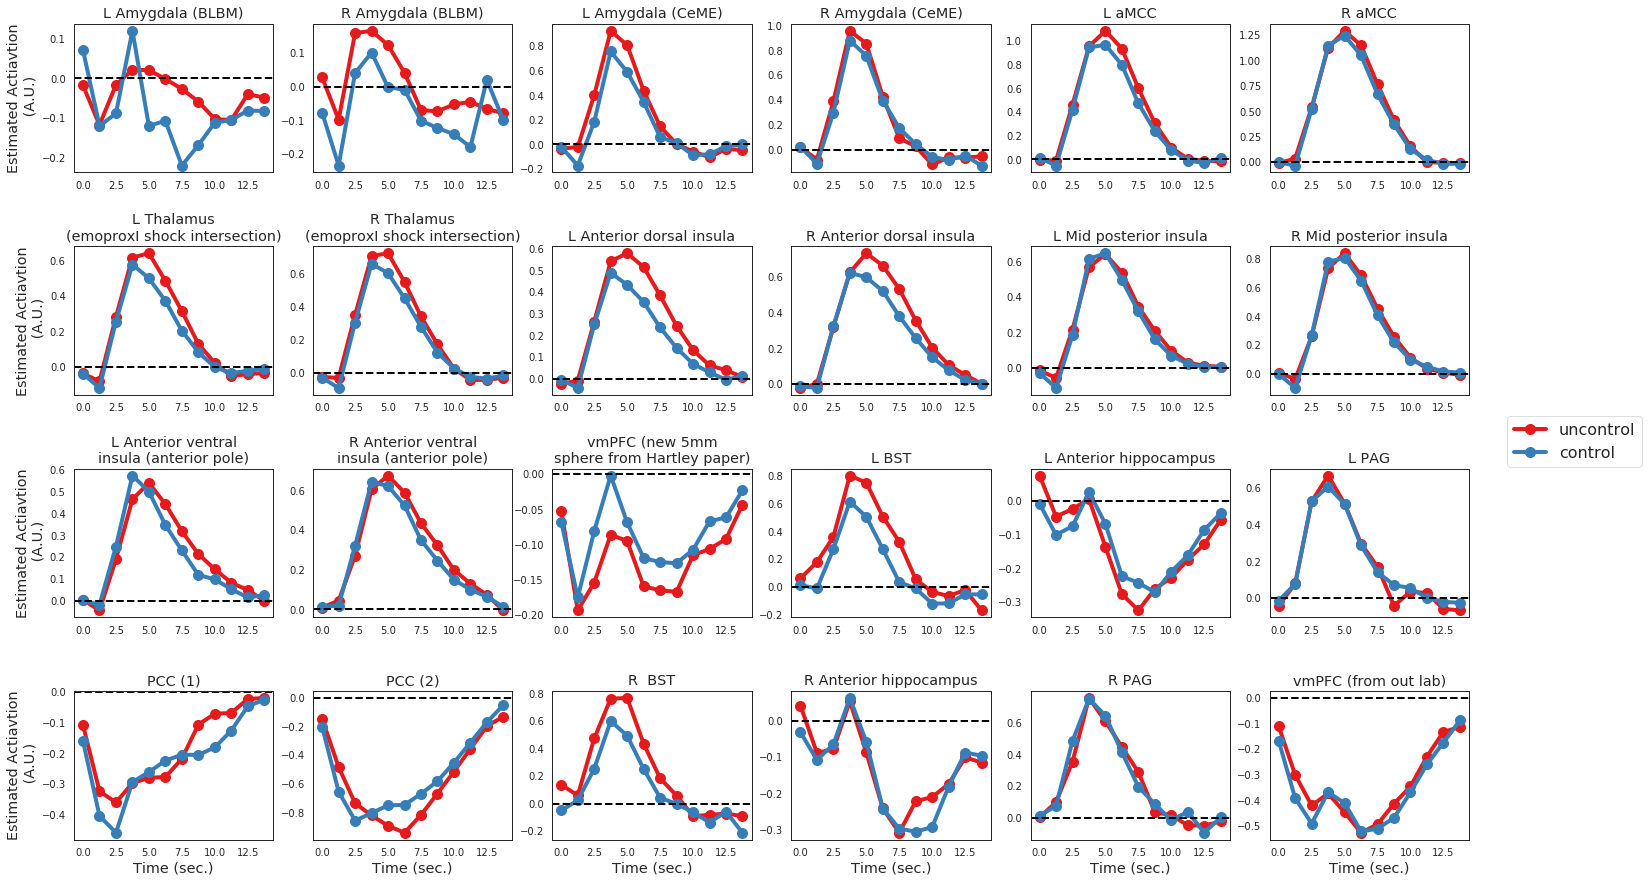

In [38]:
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

k_cols = 6
k_rows = 4
fig, axes = plt.subplots(nrows=k_rows, ncols=k_cols, sharey=False, figsize=(25,15))
axes = axes.flatten()
fig.subplots_adjust(hspace=0.5,wspace=0.2)
for i,roi in enumerate(rois):
    
    uncon_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                    & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
    uncon_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                                & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
    
    axes[i].plot(t,uncon_mean, color=cmap.colors[0],linewidth=4,marker='o',markersize=10,label='uncontrol')

    
    con_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                  & (cross_subj_mean_df['Group']=='control')]['Response'].values
    con_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                                  & (cross_subj_mean_df['Group']=='control')]['Response'].values
    
    
    axes[i].plot(t,con_mean, color=cmap.colors[1],linewidth=4,marker='o',markersize=10,label='control')

    
    axes[i].axhline(y=0,linestyle='--',linewidth=2,c='black')
    axes[i].set_xticks(t[::2])
    
    if len(roi) > 24:
        title_list = roi.split()
        first_half = ' '.join(title_list[:int(len(title_list)/2)])
        second_half = ' '.join(title_list[int(len(title_list)/2):])
        title = '\n'.join([first_half,second_half])
    else:
        title = roi
    axes[i].set_title(title)
    
    if i % k_cols == 0:
        axes[i].set_ylabel('Estimated Actiavtion\n (A.U.)')
    
    if i >= k_cols*(k_rows-1):
        axes[i].set_xlabel('Time (sec.)')
    
    
    #axes[i].legend()
main_legend_handles, main_legend_labels = axes[i].get_legend_handles_labels()
fig.legend(main_legend_handles,main_legend_labels,loc='center right',fontsize=16)
plt.figlegend(main_legend_handles,main_legend_labels, loc='right',bbox_to_anchor=(1, 0.5))
#fig.savefig('figures/estimated_shock_response.png',dpi=600)

# Visualizing estimated response just single ROI

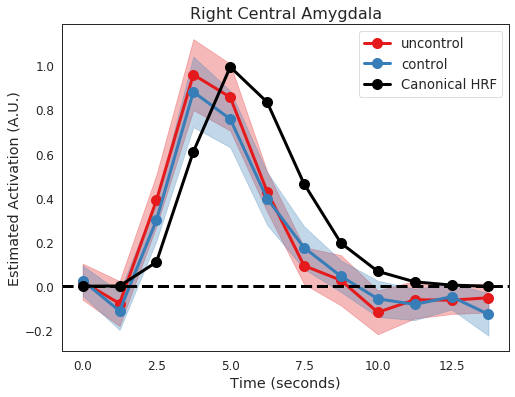

In [54]:
roi = 'Right Central Amygdala'
uncon_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
uncon_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                            & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values

plt.figure(figsize=(8,6))
plt.plot(t,uncon_mean, color=cmap.colors[0],linewidth=3,marker='o',label='uncontrol',markersize=10)
plt.fill_between(t,uncon_mean-(critT*uncon_se),
                     uncon_mean+(critT*uncon_se),
                     alpha=0.3,
                     color=cmap.colors[0])

con_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                              & (cross_subj_mean_df['Group']=='control')]['Response'].values
con_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                              & (cross_subj_mean_df['Group']=='control')]['Response'].values


plt.plot(t,con_mean, color=cmap.colors[1],linewidth=3,marker='o',label='control',markersize=10)
plt.fill_between(t,con_mean-(critT*con_se),
                     con_mean+(critT*con_se),
                     alpha=0.3,
                     color=cmap.colors[1])

plt.plot(t,HRF,color='black',linewidth=3,marker='o',label='Canonical HRF',markersize=10)

plt.axhline(y=0,linestyle='--',linewidth=3,c='black')
plt.xticks(t[0::2],fontsize=12)
plt.yticks(fontsize=12)
plt.title(roi,fontsize=16)
plt.xlabel('Time (seconds)')
plt.ylabel('Estimated Activation (A.U.)')
plt.legend()
#plt.savefig('figures/estimated_shock_response_right_central_amygdala.png')

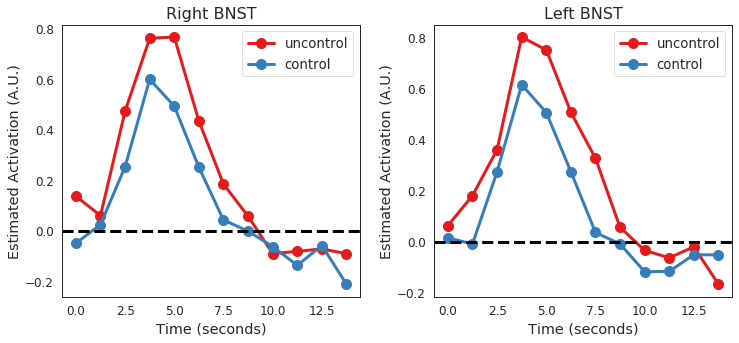

In [55]:
plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=0.25)
plt.subplot(1,2,1)
roi = 'Right BNST'
uncon_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
uncon_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                            & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values

plt.plot(t,uncon_mean, color=cmap.colors[0],linewidth=3,marker='o',label='uncontrol',markersize=10)

con_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                              & (cross_subj_mean_df['Group']=='control')]['Response'].values
con_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                              & (cross_subj_mean_df['Group']=='control')]['Response'].values


plt.plot(t,con_mean, color=cmap.colors[1],linewidth=3,marker='o',label='control',markersize=10)

plt.axhline(y=0,linestyle='--',linewidth=3,c='black')
plt.xticks(t[0::2],fontsize=12)
plt.yticks(fontsize=12)
plt.title(roi,fontsize=16)
plt.xlabel('Time (seconds)')
plt.ylabel('Estimated Activation (A.U.)')
plt.legend()

plt.subplot(1,2,2)
roi = 'Left BNST'
uncon_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
uncon_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                            & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values

plt.plot(t,uncon_mean, color=cmap.colors[0],linewidth=3,marker='o',label='uncontrol',markersize=10)

con_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                              & (cross_subj_mean_df['Group']=='control')]['Response'].values
con_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                              & (cross_subj_mean_df['Group']=='control')]['Response'].values


plt.plot(t,con_mean, color=cmap.colors[1],linewidth=3,marker='o',label='control',markersize=10)

plt.axhline(y=0,linestyle='--',linewidth=3,c='black')
plt.xticks(t[0::2],fontsize=12)
plt.yticks(fontsize=12)
plt.title(roi,fontsize=16)
plt.xlabel('Time (seconds)')
plt.ylabel('Estimated Activation (A.U.)')
plt.legend()
plt.savefig('data/estimated_shock_response_BST.png')

## Visualizing the difference in slopes

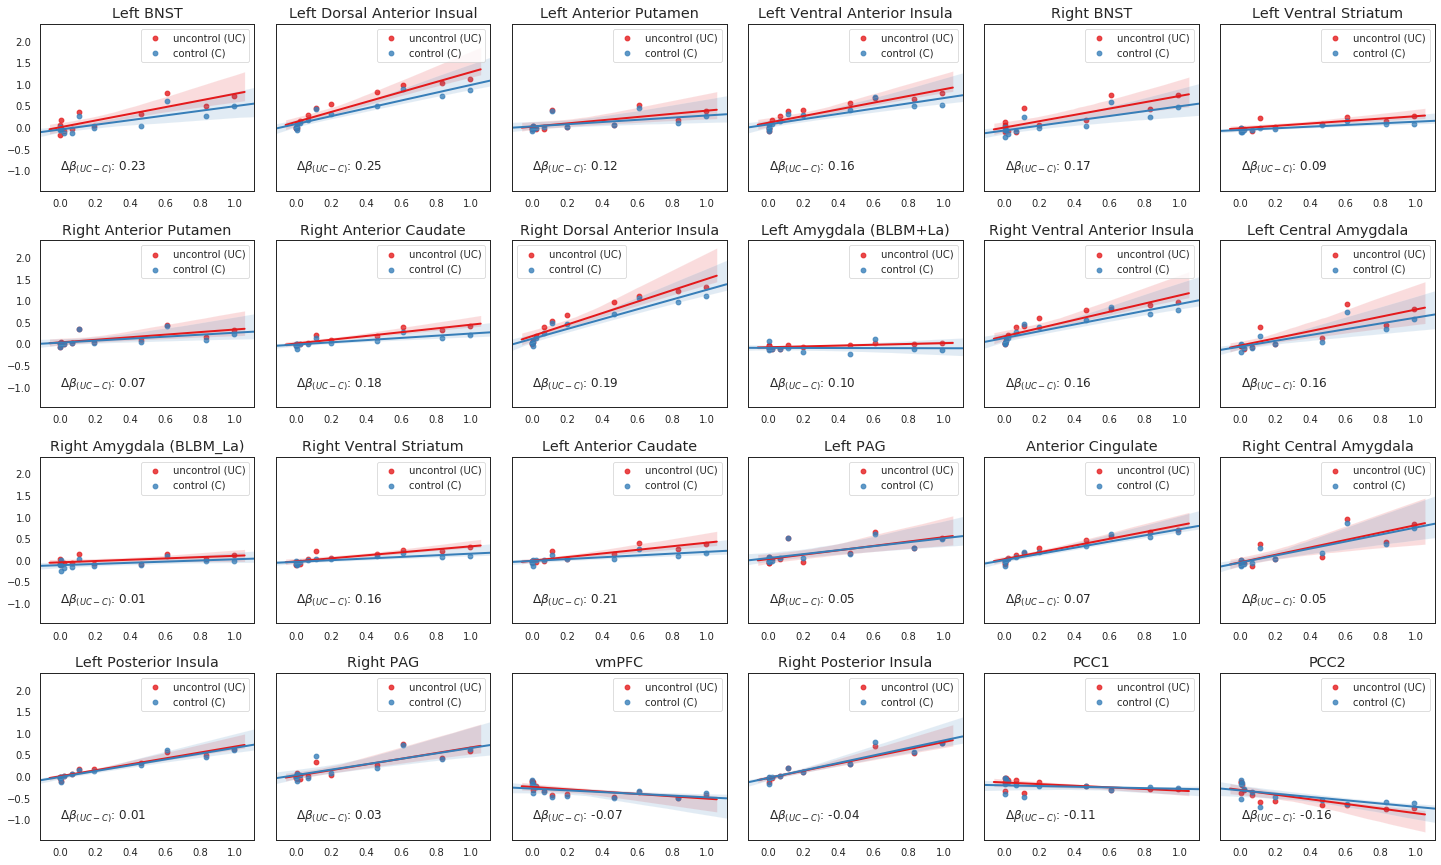

In [57]:
from scipy.stats import linregress

fig, axes = plt.subplots(nrows=4, ncols=6, sharey=True, figsize=(25,15))
axes = axes.flatten()
fig.subplots_adjust(hspace=0.3,wspace=0.1)
for i,roi in enumerate(roi_mapper.values()):
    
    uncon_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                    & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
    uncon_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                                & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
    
    sns.regplot(HRF,uncon_mean,color=cmap.colors[0],marker='o',line_kws=dict(linewidth=2),label='uncontrol (UC)',ax=axes[i])
    
    con_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                  & (cross_subj_mean_df['Group']=='control')]['Response'].values
    con_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                                  & (cross_subj_mean_df['Group']=='control')]['Response'].values
    
    sns.regplot(HRF,con_mean,color=cmap.colors[1],marker='o',line_kws=dict(linewidth=2),label='control (C)',ax=axes[i])
    
    slope_uncon, intercept_uncon, r_value_uncon, p_value_uncon, std_err_uncon = linregress(x=axes[i].get_lines()[0].get_xdata(),y=axes[i].get_lines()[0].get_ydata())
    slope_con, intercept_con, r_value_con, p_value_con, std_err_con = linregress(x=axes[i].get_lines()[1].get_xdata(),y=axes[i].get_lines()[1].get_ydata())
    
    axes[i].text(0,-1,r'$\Delta\beta_{(UC-C)}$: %.2f' %(slope_uncon-slope_con),fontsize=12)
    
    axes[i].set_title(roi)
    axes[i].legend(fontsize=10)

#fig.savefig('figures/slopes_estimated_shock_response.png',dpi=600)

## Plotting difference within each yoked pair

In [58]:
df[df['Group']=='control'].head()

,Pair,Group,SubjID,Time,ROI,Response
0,P00,control,CON001,0.00,Right BNST,-0.143839
1,P00,control,CON001,1.25,Right BNST,-0.750368
2,P00,control,CON001,2.50,Right BNST,0.568196
3,P00,control,CON001,3.75,Right BNST,-0.002206
4,P00,control,CON001,5.00,Right BNST,1.282580


In [59]:
df[df['Group']=='uncontrol'].head()

,Pair,Group,SubjID,Time,ROI,Response
12,P00,uncontrol,CON031,0.00,Right BNST,1.285400
13,P00,uncontrol,CON031,1.25,Right BNST,0.574188
14,P00,uncontrol,CON031,2.50,Right BNST,0.177713
15,P00,uncontrol,CON031,3.75,Right BNST,1.068380
16,P00,uncontrol,CON031,5.00,Right BNST,0.981429


## Creating paired difference df

In [61]:
paired_df = pd.DataFrame()
for i,row in yoked.iterrows():
    for roi in roi_mapper.values():
        uc_resp = df[(df['Pair'] == 'P{:02d}'.format(i)) & (df['SubjID']==row['uncontrol']) & (df['ROI']==roi)]['Response'].values
        c_resp = df[(df['Pair'] == 'P{:02d}'.format(i)) & (df['SubjID']==row['control']) & (df['ROI']==roi)]['Response'].values
        
        tmp_df = pd.DataFrame({'Time':list(np.arange(uc_resp.size)*1.25),
                               'ROI':roi,
                               'Response':uc_resp-c_resp})
        paired_df = pd.concat([paired_df,tmp_df],axis=0)

In [62]:
paired_df.shape

(17568, 3)

In [63]:
paired_df.head()

,Time,ROI,Response
0,0.00,Left BNST,1.093907
1,1.25,Left BNST,1.523006
2,2.50,Left BNST,-0.872480
3,3.75,Left BNST,1.847421
4,5.00,Left BNST,0.564309


In [64]:
cross_pair_mean_df = paired_df.groupby(['ROI','Time']).mean().reset_index()
cross_pair_mean_df.head()

,ROI,Time,Response
0,Anterior Cingulate,0.00,-0.013418
1,Anterior Cingulate,1.25,0.045171
2,Anterior Cingulate,2.50,-0.008763
3,Anterior Cingulate,3.75,-0.028015
4,Anterior Cingulate,5.00,0.066303


In [65]:
cross_pair_se_df = paired_df.groupby(['ROI','Time']).agg(sem).reset_index()
cross_pair_se_df.head()

,ROI,Time,Response
0,Anterior Cingulate,0.00,0.023279
1,Anterior Cingulate,1.25,0.040126
2,Anterior Cingulate,2.50,0.041657
3,Anterior Cingulate,3.75,0.045361
4,Anterior Cingulate,5.00,0.049171


## Compare with the assummed shape estimates

In [72]:
df_MR = pd.read_csv('uncon_v_con_shock_MR_ROI24_with_covariates/uncon_v_con_shock_MR_ROI24_with_covariates2.txt',sep='\t')
df_MR.head()

,Subj,ROI,Y,TRAITmean,TRAITdiff,STATEmean,STATEdiff
0,P00,vmPFC,-0.0544,-1.003,-0.0406,-1.2307,-0.1812
1,P00,PCC1,0.5107,-1.003,-0.0406,-1.2307,-0.1812
2,P00,PCC2,0.3733,-1.003,-0.0406,-1.2307,-0.1812
3,P00,rPAG,0.7424,-1.003,-0.0406,-1.2307,-0.1812
4,P00,lPAG,-0.0949,-1.003,-0.0406,-1.2307,-0.1812


In [73]:
from scipy.stats import ttest_1samp

In [117]:
ttest_table = pd.DataFrame()
for roi in rois:
    samp = df_MR[df_MR['ROI']==roi]['Y'].values
    tstat, p = ttest_1samp(samp,0)
    tmp_df = pd.DataFrame([roi_mapper[roi],np.round(tstat,8), np.round(p,8)],index=['ROI','t-stat','p-value']).T
    ttest_table = pd.concat([ttest_table,tmp_df],axis = 0)
ttest_table.sort_values('p-value',inplace=True)
ttest_table.reset_index(drop=True,inplace=True)

In [118]:
ttest_table

,ROI,t-stat,p-value
0,Left Anterior Caudate,3.86723,0.00027342
1,Left Dorsal Anterior Insual,3.43075,0.00109507
2,Right Anterior Caudate,3.0691,0.00322152
3,Left BNST,2.88075,0.00549467
4,Right Ventral Striatum,2.43172,0.0180296
5,Right Dorsal Anterior Insula,2.24907,0.0281909
6,Left Ventral Anterior Insula,2.0967,0.0402444
7,Right BNST,2.03993,0.0457667
8,PCC2,-1.91314,0.0605052
9,Left Anterior Putamen,1.77501,0.0809683


/home/climbach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


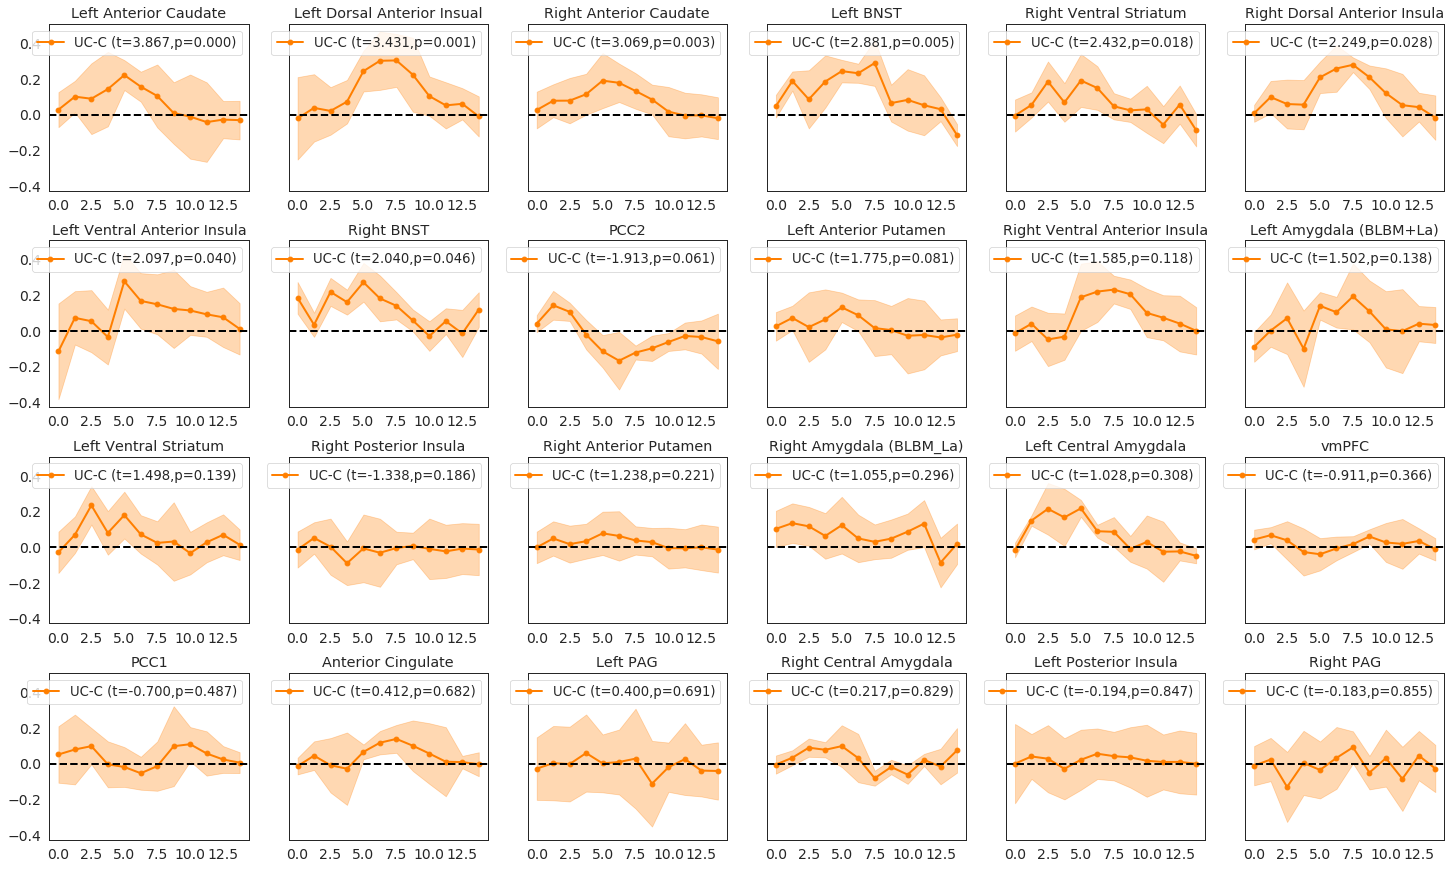

In [119]:
fig, axes = plt.subplots(nrows=4, ncols=6, sharey=True, figsize=(25,15))
axes = axes.flatten()
fig.subplots_adjust(hspace=0.3,wspace=0.2)
#for i,roi in enumerate(roi_mapper.values()):
for i,roi in enumerate(ttest_table.ROI.unique()):
    pair_mean = cross_pair_mean_df[cross_pair_mean_df['ROI']==roi]['Response'].values
    pair_se = cross_pair_se_df[cross_subj_se_df['ROI']==roi]['Response'].values
    
    tstat, p = ttest_table[ttest_table['ROI']==roi].values[0][1:].tolist()
    axes[i].plot(t,pair_mean, color=cmap.colors[4],linewidth=2,marker='o',label='UC-C (t=%.3f,p=%.3f)'%(tstat,p))
    axes[i].fill_between(t,pair_mean-(critT*pair_se),
                         pair_mean+(critT*pair_se),
                         alpha=0.3,
                         color=cmap.colors[4])
    
    axes[i].axhline(y=0,linestyle='--',linewidth=2,c='black')
    axes[i].set_xticks(t[::2])
    axes[i].set_title(roi)
    axes[i].legend()

#fig.savefig('figures/uncon_v_con_estimated_shock_response.png',dpi=600)

# Creating inset plot 

/home/climbach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


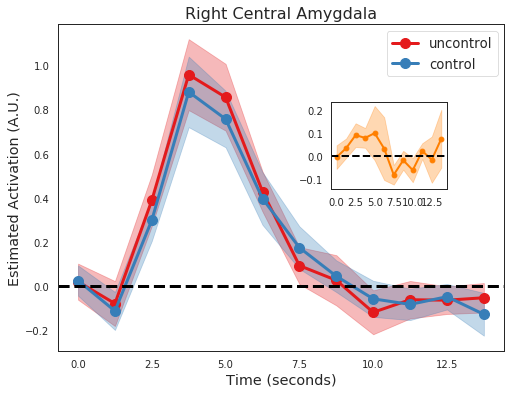

In [77]:
roi = 'Right Central Amygdala'
uncon_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
uncon_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                            & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values

fig, ax1 = plt.subplots(figsize=(8,6),sharey=True)

right, top, width, heigh = [0.6,0.5,0.2,0.2]
ax2 = fig.add_axes([right,top,width,heigh])


ax1.plot(t,uncon_mean, color=cmap.colors[0],linewidth=3,marker='o',label='uncontrol',markersize=10)
ax1.fill_between(t,uncon_mean-(critT*uncon_se),
                     uncon_mean+(critT*uncon_se),
                     alpha=0.3,
                     color=cmap.colors[0])

con_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                              & (cross_subj_mean_df['Group']=='control')]['Response'].values
con_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                              & (cross_subj_mean_df['Group']=='control')]['Response'].values


ax1.plot(t,con_mean, color=cmap.colors[1],linewidth=3,marker='o',label='control',markersize=10)
ax1.fill_between(t,con_mean-(critT*con_se),
                     con_mean+(critT*con_se),
                     alpha=0.3,
                     color=cmap.colors[1])



ax1.axhline(y=0,linestyle='--',linewidth=3,c='black')
ax1.set_xticks(t[0::2])
#ax1.set_yticks()
ax1.set_title(roi,fontsize=16)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Estimated Activation (A.U.)')
ax1.legend()



### Inset
pair_mean = cross_pair_mean_df[cross_pair_mean_df['ROI']==roi]['Response'].values
pair_se = cross_pair_se_df[cross_subj_se_df['ROI']==roi]['Response'].values

#tstat, p = ttest_table[ttest_table['ROI']==roi].values[0][1:].tolist()
ax2.plot(t,pair_mean, color=cmap.colors[4],linewidth=2,marker='o',label='UC-C (t=%.3f,p=%.3f)'%(tstat,p))
ax2.fill_between(t,pair_mean-(critT*pair_se),
                     pair_mean+(critT*pair_se),
                     alpha=0.3,
                     color=cmap.colors[4])

ax2.axhline(y=0,linestyle='--',linewidth=2,c='black')
ax2.set_xticks(t[::2])
#ax2.set_title(roi)
#ax2.legend()
#plt.savefig('figures/estimated_shock_response_right_central_amygdala.png')

/home/climbach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


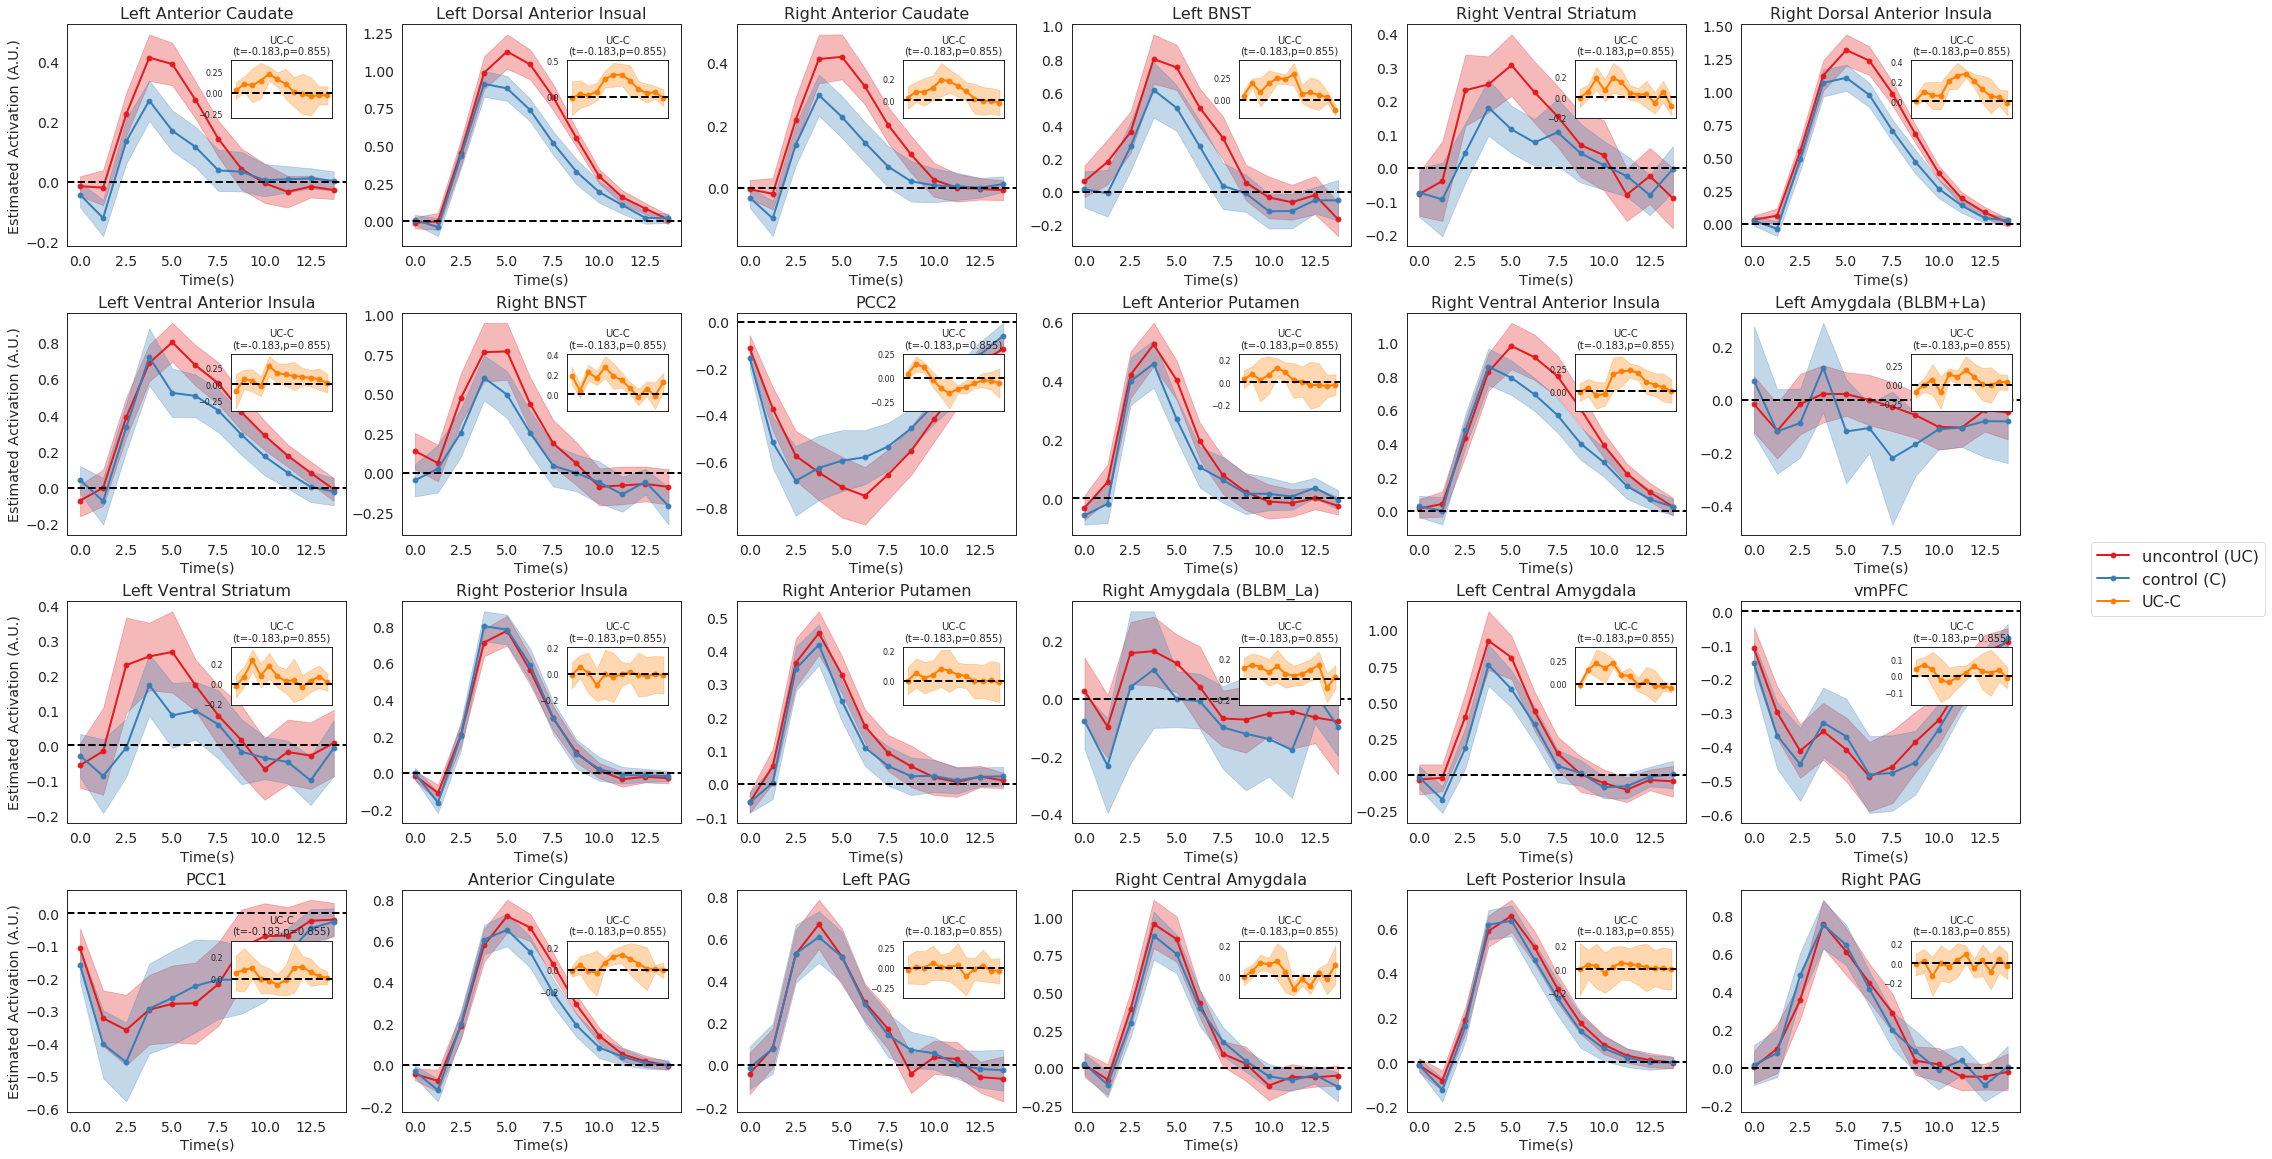

In [123]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

fig, axes = plt.subplots(nrows=4, ncols=6, sharey=False, figsize=(35,20))
axes = axes.flatten()

FIGWIDTH = fig.get_figwidth()
FIGHEIGHT = fig.get_figwidth()
k_cols = 6
k_rows = 4

fig.subplots_adjust(hspace=0.3,wspace=0.2)

right, top, width, heigh = [0.19,0.815,0.04,0.04]

for i,roi in enumerate(ttest_table.ROI.unique()):
    
    uncon_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                    & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
    uncon_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                                & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
    
    axes[i].plot(t,uncon_mean, color=cmap.colors[0],linewidth=2,marker='o',label='uncontrol (UC)')
    axes[i].fill_between(t,uncon_mean-(critT*uncon_se),
                         uncon_mean+(critT*uncon_se),
                         alpha=0.3,
                         color=cmap.colors[0])
    
    
    con_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                  & (cross_subj_mean_df['Group']=='control')]['Response'].values
    con_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                                  & (cross_subj_mean_df['Group']=='control')]['Response'].values
    
    
    axes[i].plot(t,con_mean, color=cmap.colors[1],linewidth=2,marker='o',label='control (C)')
    axes[i].fill_between(t,con_mean-(critT*con_se),
                         con_mean+(critT*con_se),
                         alpha=0.3,
                         color=cmap.colors[1])
    
    
    axes[i].axhline(y=0,linestyle='--',linewidth=2,c='black')
    axes[i].set_xticks(t[::2])
    axes[i].set_title(roi,fontsize=16)
    axes[i].set_xlabel('Time(s)')
    
    row = int(i/k_cols)
    col = (i%k_cols)
    
    if col == 0:
        axes[i].set_ylabel('Estimated Activation (A.U.)')
    
    ### Inset
    
   
    
    #if i == 0:
    ax2 = fig.add_axes([right+(right*col/1.425),top-(top*row/4),width,heigh])

    pair_mean = cross_pair_mean_df[cross_pair_mean_df['ROI']==roi]['Response'].values
    pair_se = cross_pair_se_df[cross_subj_se_df['ROI']==roi]['Response'].values

    #tstat, p = ttest_table[ttest_table['ROI']==roi].values[0][1:].tolist()
    ax2.plot(t,pair_mean, color=cmap.colors[4],linewidth=2,marker='o',label='UC-C')
    ax2.fill_between(t,pair_mean-(critT*pair_se),
                         pair_mean+(critT*pair_se),
                         alpha=0.3,
                         color=cmap.colors[4])
    ax2.set_xticks([])
    #ax2.set_xlabel('Time',fontsize=8)
    ax2.tick_params(axis="y", labelsize=8) 
    ax2.axhline(y=0,linestyle='--',linewidth=2,c='black')
    ax2.set_title('UC-C\n(t=%.3f,p=%.3f)'%(tstat,p),fontsize=10)
    
    

main_legend_handles, main_legend_labels = axes[i].get_legend_handles_labels()
inset_legend_handles, inset_legend_labels = ax2.get_legend_handles_labels()
fig.legend(main_legend_handles+inset_legend_handles,main_legend_labels+inset_legend_labels,loc='center right',fontsize=16)
plt.figlegend(main_legend_handles+inset_legend_handles,main_legend_labels+inset_legend_labels, loc='right',bbox_to_anchor=(1, 0.5))
fig.savefig('data/estimated_shock_response.png',dpi=600)